In [7]:
import pandas as pd
import cudf
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import seaborn as sns 
import xgboost
import mlflow
from sklearn.model_selection import train_test_split
# from cuml.model_selection import train_test_split


In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [9]:
import cudf, cuml, cupy
# from cuml.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [10]:
from sklearn.svm import SVC

In [11]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [12]:
mlflow.autolog()

2023/01/16 00:59:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/01/16 00:59:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/01/16 00:59:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [13]:
plot_params = {
    'font.family': 'Ubuntu',
    'font.weight': 'light',
    
    'figure.figsize': (15,5),
    'figure.frameon': False, 
    'figure.titlesize': 'xx-large',
    'figure.titleweight': 'normal',
    
    'axes.titlesize': 'x-large',
    'axes.titlecolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlelocation': 'center',
    'axes.labelsize': 'x-large',

    'grid.alpha': .25, 
    'legend.frameon':False,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
}

In [14]:
pylab.rcParams.update(plot_params)
sns.set_palette('mako')

In [15]:
SEED = 1943
np.random.seed(SEED)

In [16]:
os.listdir('data')

['Lyrics-Genre-Test-GroundTruth.csv', 'Lyrics-Genre-Train.csv']

In [17]:
TRAIN_PATH = 'data/Lyrics-Genre-Train.csv'
TEST_PATH = 'data/Lyrics-Genre-Test-GroundTruth.csv'

In [18]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

In [29]:
X_train, Y_train = train_data[['Lyrics']], train_data['Genre']

X_test, Y_test = test_data[['Lyrics']], test_data['Genre']

In [54]:
train_data

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260
...,...,...,...,...,...,...
18508,i-wish-he-didn-t-trust-me-so-much,2008,bobby-womack,R&B,I'm the best friend he's got\nI'd give him the...,12033
18509,i-totally-miss-you,2006,bad-boys-blue,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you...",15987
18510,sorry-for-love,2002,celine-dion,Pop,Forgive me for the things\nThat I never said t...,2722
18511,cure-for-aids,2008,dan-bern,Indie,The day they found a cure for AIDS\nThe day th...,10221


In [31]:
X_train

,Lyrics
0,"I am a night in to the darkness, only soul los..."
1,"Yeah\nSometimes, i just wanna fly away.\nThey ..."
2,Do you work hard?\nDo you work hard?\nYou don'...
3,You know what? I'm destined to be the last man...
4,There ain't nothing that I would rather see\nT...
...,...
18508,I'm the best friend he's got\nI'd give him the...
18509,"Bad Boys Blue\n""I Totally Miss You""\nI did you..."
18510,Forgive me for the things\nThat I never said t...
18511,The day they found a cure for AIDS\nThe day th...


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
Y_train = label_encoder.transform(Y_train)
Y_test = label_encoder.transform(Y_test)

In [16]:
# Y_train = Y_train.astype('category').cat.codes
# Y_test = Y_test.astype('category').cat.codes

In [23]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(18513,) (18513,) (7935,) (7935,)


In [55]:
train, valid = train_test_split(train_data, test_size= .15, random_state = SEED, stratify = train_data['Genre'])

In [ ]:

train.loc[:,'Genre'] = label_encoder.transform(train.loc[:,'Genre'])
valid.loc[:,'Genre'] = label_encoder.transform(valid.loc[:,'Genre'])

In [24]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size= .15, random_state = SEED, stratify = Y_train)

In [19]:
# # Cudf series
# X_train_ = cudf.Series(X_train)
# X_valid_ = cudf.Series(X_valid)
# Y_train_ = cudf.Series(Y_train)
# Y_valid_ = cudf.Series(Y_valid)

#### EDA

In [19]:
train_data.shape

(18513, 6)

In [20]:
train_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260


In [21]:
test_data.shape

(7935, 6)

In [22]:
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


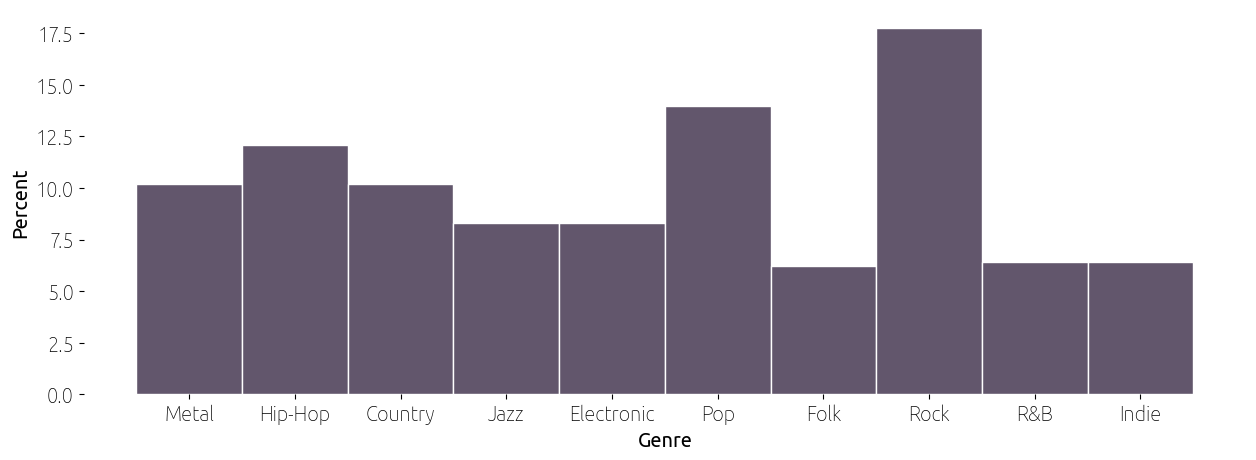

In [23]:
sns.histplot(train_data['Genre'], edgecolor = 'white', stat = 'percent')
plt.box(False)
plt.show()


In [24]:
train_data['Genre'].nunique()

10

There are 10 classes. A somewhat unbalanced dataset. Three classes with less than 5% samples. The majority class being Rock w/ approximately 18% of the entries.

In [25]:
train_data.groupby('Genre')['Lyrics']

Some samples from each group, should be checked.

#### Modeling

In [88]:
# Tracking
mlflow.get_tracking_uri()

'file:///home/mikhailtal/Desktop/hnnaharendt/lyrics-project/mlruns'

In [89]:
mlflow.autolog()

2023/01/15 18:07:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/01/15 18:07:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/01/15 18:07:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [90]:
# mlflow.set_experiment(
#     experiment_name = 'lyrics-cls'
# )

In [91]:
label_encoder.classes_.tolist()

['Country',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Metal',
 'Pop',
 'R&B',
 'Rock']

In [92]:
# Define metrics
def calculate_metrics(Y_true, Y_pred, log = True, verbose = True):
    """ Logging custom metrics of interest to the mlflow server"""
    
    # Metrics
    acc = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred, average = 'weighted')
    precision = precision_score(Y_true, Y_pred, average= 'weighted')
    recall = recall_score(Y_true, Y_pred, average = 'weighted')
    mcc = matthews_corrcoef(Y_true, Y_pred)
    cls_report = classification_report(Y_true, Y_pred, target_names=label_encoder.classes_.tolist())
    
    # Logging 
    mlflow.log_metric(key = 'accuracy', value = acc )
    mlflow.log_metric(key = 'f1_score', value = f1  )
    mlflow.log_metric(key = 'precision', value = precision)
    mlflow.log_metric(key = 'recall', value = recall)
    mlflow.log_metric(key = 'matthews', value = mcc)
    
    # Display results in notebook
    if verbose:
        print('Metrics:')
        print(f'\t Accuracy \t\t{acc}')
        print(f'\t F-Score \t\t{f1 }')
        print(f'\t Precision \t\t{precision}')
        print(f'\t Recall \t\t{recall}')
        print(f"\t Matthew's cc \t\t{mcc}")
        print(f'\n{cls_report}')

    

In [93]:
mlflow.set_experiment(experiment_name='lyrics-classification')

<Experiment: artifact_location='file:///home/mikhailtal/Desktop/hnnaharendt/lyrics-project/mlruns/741618519818827325', creation_time=1673731441480, experiment_id='741618519818827325', last_update_time=1673731441480, lifecycle_stage='active', name='lyrics-classification', tags={}>

#### HF

In [126]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [155]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [138]:
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_linear_schedule_with_warmup

In [3]:
MODEL_NAME = 'microsoft/debase_modela-large'
DOWNLOADED_MODEL_PATH = './model/microsoft/debase_modela-large'

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path= MODEL_NAME,
    add_prefix_space = True
)
model_config = AutoConfig.from_pretrained(MODEL_NAME, add_prefix_space = True)
model_base = AutoModel.from_pretrained(MODEL_NAME, config = model_config)

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [134]:
class LyricsDataset(Dataset):
    def __init__(
        self, input_data, tokenizer, max_len, return_pt=True) -> None:
        self.input_data = input_data
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.return_pt = return_pt

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        row = self.input_data.iloc[idx]
        lyrics_text = row['Lyrics']
        label = row['Genre']
        
        if self.return_pt:
            label = torch.tensor(label)

        encoding = self.tokenizer.encode_plus(
           text = lyrics_text,
           add_special_tokens = True,
           padding = 'max_length',
           truncation = True,
           max_length = self.max_len,
        
        
           return_attention_mask = True,
           return_token_type_ids = False,

           return_tensors = 'pt' if self.return_pt else 'np'
        )

        return dict(
            lyrics_text = lyrics_text,
            input_ids = encoding['input_ids'].flatten(),
            attention_mask = encoding['attention_mask'].flatten(),
            label = label
        )

       

In [135]:
class LyricsDataModule(pl.LightningDataModule):
    def __init__(self, train, valid, test, tokenizer, batch_size = 16, max_token_length = 256) -> None:
        super().__init__()
    
        self.train_data = train
        self.valid_data = valid
        
        if test:
            self.test_data = test
        else:
            self.test_data = None

        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_length = max_token_length

    def setup(self, stage = None) -> None:
        self.train_dataset = LyricsDataset(self.train_data, tokenizer = tokenizer, max_len=256)

        self.valid_dataset = LyricsDataset(self.valid_data, tokenizer = tokenizer, max_len=256)

        if self.test_data:
            self.test_dataset = LyricsDataset(self.test_data, tokenizer = tokenizer, max_len=256)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size= self.batch_size,
            shuffle=True,
            num_workers=8
        )
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size= self.batch_size,
            shuffle=False,
            num_workers=8
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size= self.batch_size,
            shuffle=False,
            num_workers=8
        )

In [175]:
class LyricsClassifier(pl.LightningModule):
  def __init__(self, model_name, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    model_config = AutoConfig.from_pretrained(model_name, add_prefix_space = True)
    self.base_model = AutoModel.from_pretrained(model_name, config = model_config)
    
    self.classifier = nn.Linear(self.base_model.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()
    
  def forward(self, input_ids, attention_mask, label=None):
    output = self.base_model(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    
    loss = 0
    if label is not None:
        loss = self.criterion(output, label)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "label": label}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  
  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [176]:
data_mod = LyricsDataModule(train, valid, None, tokenizer)
data_mod.setup()

In [177]:
model_checkpoint = "distilbase_model-base-uncased"

In [178]:
steps_per_epoch=len(train) // 16
total_training_steps = steps_per_epoch * 20

In [179]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(3932, 19660)

In [184]:
model_.base_model

DebertaModel(
  (embeddings): DebertaEmbeddings(
    (word_embeddings): Embedding(50265, 1024, padding_idx=0)
    (LayerNorm): DebertaLayerNorm()
    (dropout): StableDropout()
  )
  (encoder): DebertaEncoder(
    (layer): ModuleList(
      (0): DebertaLayer(
        (attention): DebertaAttention(
          (self): DisentangledSelfAttention(
            (in_proj): Linear(in_features=1024, out_features=3072, bias=False)
            (pos_dropout): StableDropout()
            (pos_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (pos_q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): StableDropout()
          )
          (output): DebertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): DebertaLayerNorm()
            (dropout): StableDropout()
          )
        )
        (intermediate): DebertaIntermediate(
          (dense): Linear(in_features=1024, out_features=

In [180]:
model_ = LyricsClassifier(model_name=MODEL_NAME, n_classes=10, n_warmup_steps = warmup_steps, n_training_steps = total_training_steps)

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [181]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
logger = TensorBoardLogger("lightning_logs", name="lyrics_classification")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [182]:
trainer = pl.Trainer(
  logger=logger,
  
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=10,
  gpus=1,
  num_sanity_val_steps=-1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [183]:
trainer.fit(model_, data_mod)

2023/01/16 02:26:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '594f9efdafb04217b746113080b59b20', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
Missing logger folder: lightning_logs/lyrics_classification
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | base_model | DebertaModel     | 405 M 
1 | classifier | Linear           | 10.2 K
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
405 M     Trainable params
0         Non-trainable params
405 M     Total params
1,620.693 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

AttributeError: 'BaseModelOutput' object has no attribute 'pooler_output'

#### Clean texts

In [31]:
def preprocess_texts():
    ...

In [94]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [95]:
type(X_train_)

cudf.core.series.Series

In [96]:

type(X_train)

pandas.core.series.Series

In [97]:
vectorizer.fit(X_train)
xtrain = vectorizer.transform(X_train)
xvalid = vectorizer.transform(X_valid)

In [98]:
print(xtrain.shape, xvalid.shape)
print(type(xtrain))

(15736, 831805) (2777, 831805)
<class 'scipy.sparse._csr.csr_matrix'>


In [99]:
model = SVC()
model.fit(xtrain, Y_train)

2023/01/15 18:17:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID a93c68c16132443796cf7be767f0af6a. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'verbose\' was already logged with value=\'0\' for run ID=\'a93c68c16132443796cf7be767f0af6a\'. Attempted logging new value \'False\'.")]')]


SVC()

In [100]:
Y_pred = model.predict(xvalid)

CountVectorizer; ngram = (1,1)

In [101]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.39250990277277636
	 F-Score 		0.35207219171845683
	 Precision 		0.5579499016688811
	 Recall 		0.39250990277277636
	 Matthew's cc 		0.31375231055310915

              precision    recall  f1-score   support

     Country       0.48      0.30      0.37       284
  Electronic       0.82      0.04      0.07       231
        Folk       0.70      0.09      0.16       173
     Hip-Hop       0.83      0.78      0.80       336
       Indie       1.00      0.02      0.03       178
        Jazz       0.61      0.13      0.21       231
       Metal       0.64      0.66      0.65       283
         Pop       0.29      0.35      0.32       389
         R&B       0.50      0.03      0.06       178
        Rock       0.25      0.71      0.37       494

    accuracy                           0.39      2777
   macro avg       0.61      0.31      0.31      2777
weighted avg       0.56      0.39      0.35      2777




CountVectorizer; ngram = (1,2)

In [34]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.39683111271155924
	 F-Score 		0.39683111271155924
	 Precision 		0.39683111271155924
	 Recall 		0.39683111271155924
	 Matthew's cc 		0.312109871634615

              precision    recall  f1-score   support

           0       0.46      0.38      0.42       284
           1       0.26      0.12      0.16       231
           2       0.49      0.20      0.28       173
           3       0.84      0.79      0.81       336
           4       0.24      0.06      0.09       178
           5       0.41      0.27      0.32       231
           6       0.59      0.61      0.60       283
           7       0.30      0.35      0.33       389
           8       0.32      0.12      0.17       178
           9       0.25      0.53      0.34       494

    accuracy                           0.40      2777
   macro avg       0.42      0.34      0.35      2777
weighted avg       0.42      0.40      0.38      2777



CountVectorizer; ngram = (1,3)

In [47]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.409074540871444
	 F-Score 		0.409074540871444
	 Precision 		0.409074540871444
	 Recall 		0.409074540871444
	 Matthew's cc 		0.3269972964211144

              precision    recall  f1-score   support

           0       0.45      0.39      0.42       284
           1       0.26      0.12      0.17       231
           2       0.53      0.23      0.32       173
           3       0.83      0.79      0.81       336
           4       0.26      0.06      0.09       178
           5       0.44      0.28      0.34       231
           6       0.59      0.63      0.61       283
           7       0.31      0.33      0.32       389
           8       0.38      0.14      0.20       178
           9       0.27      0.58      0.37       494

    accuracy                           0.41      2777
   macro avg       0.43      0.35      0.36      2777
weighted avg       0.43      0.41      0.39      2777



TFidf

In [61]:

calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.21389989196975154
	 F-Score 		0.21389989196975154
	 Precision 		0.21389989196975154
	 Recall 		0.21389989196975154
	 Matthew's cc 		0.10649674176783724

              precision    recall  f1-score   support

           0       0.24      0.10      0.14       284
           1       0.10      0.32      0.16       231
           2       0.60      0.03      0.07       173
           3       0.92      0.39      0.55       336
           4       0.09      0.17      0.12       178
           5       0.55      0.03      0.05       231
           6       0.61      0.04      0.07       283
           7       0.22      0.30      0.25       389
           8       1.00      0.04      0.08       178
           9       0.20      0.37      0.26       494

    accuracy                           0.21      2777
   macro avg       0.45      0.18      0.17      2777
weighted avg       0.43      0.21      0.20      2777



In [73]:

calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.17788980914656105
	 F-Score 		0.17788980914656105
	 Precision 		0.17788980914656105
	 Recall 		0.17788980914656105
	 Matthew's cc 		0.0

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       284
           1       0.00      0.00      0.00       231
           2       0.00      0.00      0.00       173
           3       0.00      0.00      0.00       336
           4       0.00      0.00      0.00       178
           5       0.00      0.00      0.00       231
           6       0.00      0.00      0.00       283
           7       0.00      0.00      0.00       389
           8       0.00      0.00      0.00       178
           9       0.18      1.00      0.30       494

    accuracy                           0.18      2777
   macro avg       0.02      0.10      0.03      2777
weighted avg       0.03      0.18      0.05      2777



/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera